# Jupyter Notebook to Analyize and Visualize Dopaminergic Neuron Quantification csv data (Kristen's Data)

# 1. Importing Packages Required (No input required, just run)

In [1]:
import pandas as pd #<- package used to import and organize data
import numpy as np #<- package used to import and organize data
import seaborn as sns #<- package used to plot graphs
from matplotlib import pyplot as plt #<- package used to plot graphs
import os #<- package used to work with system filepaths
from ipywidgets import widgets #<- widget tool to generate button
from IPython.display import display #<- displays button
# from tkinter import Tk, filedialog #<- Tkinter is a GUI package
from tqdm.notebook import tqdm
from ipyfilechooser import FileChooser
# import dask.dataframe as dd
import pingouin as pg
import random
pd.set_option('display.max_columns', 50)
print("done step 1")

done step 1


In [12]:
starting_directory='/Users/Joseph/Desktop/'
chooser=FileChooser(starting_directory)
display(chooser)

FileChooser(path='/Users/Joseph/Desktop', filename='', title='', show_hidden=False, select_desc='Select', chan…

In [3]:
folder_path=chooser.selected_path
print(folder_path)

/Users/Joseph/Desktop


In [4]:
CurvedCEP = pd.read_csv(chooser.selected)

In [5]:
print(CurvedCEP)
CurvedCEP = CurvedCEP.dropna(axis=1)
print("-"*50)
print(CurvedCEP)

         Genotype  4 D.O.  7 D.O.  Unnamed: 3  Unnamed: 4  Unnamed: 5  \
0        Wildtype       0       7         NaN         NaN         NaN   
1        TH•cat-2       8      35         NaN         NaN         NaN   
2    PINK1•pink-1       4      35         NaN         NaN         NaN   
3      PRKN•pdr-1       8      25         NaN         NaN         NaN   
4    VPS35•vps-35      19      46         NaN         NaN         NaN   
5  ATP13A2•catp-7      21      35         NaN         NaN         NaN   
6     DJ1•djr-1.1      25      65         NaN         NaN         NaN   

   Unnamed: 6  Unnamed: 7  Unnamed: 8  Unnamed: 9  Unnamed: 10  Unnamed: 11  \
0         NaN         NaN         NaN         NaN          NaN          NaN   
1         NaN         NaN         NaN         NaN          NaN          NaN   
2         NaN         NaN         NaN         NaN          NaN          NaN   
3         NaN         NaN         NaN         NaN          NaN          NaN   
4         NaN       

In [6]:
CurvedCEP = pd.melt(CurvedCEP, id_vars = ['Genotype'], value_vars = ['4 D.O.', '7 D.O.'], var_name = 'Age', value_name = '% Worms')
print(CurvedCEP)

          Genotype     Age  % Worms
0         Wildtype  4 D.O.        0
1         TH•cat-2  4 D.O.        8
2     PINK1•pink-1  4 D.O.        4
3       PRKN•pdr-1  4 D.O.        8
4     VPS35•vps-35  4 D.O.       19
5   ATP13A2•catp-7  4 D.O.       21
6      DJ1•djr-1.1  4 D.O.       25
7         Wildtype  7 D.O.        7
8         TH•cat-2  7 D.O.       35
9     PINK1•pink-1  7 D.O.       35
10      PRKN•pdr-1  7 D.O.       25
11    VPS35•vps-35  7 D.O.       46
12  ATP13A2•catp-7  7 D.O.       35
13     DJ1•djr-1.1  7 D.O.       65


In [21]:
CurvedCEP_Stats = CurvedCEP.copy().rename(columns={"% Worms":"Kinked"})
CurvedCEP_Stats["Normal"] = 100-CurvedCEP_Stats.Kinked
CurvedCEP_Stats['Group'] = CurvedCEP_Stats['Genotype'] + "_" + CurvedCEP_Stats['Age']
CurvedCEP_Stats = CurvedCEP_Stats.drop(columns = ['Genotype','Age']).set_index('Group')
CurvedCEP_Stats

,Kinked,Normal
Group,,
Wildtype_4 D.O.,0,100
TH•cat-2_4 D.O.,8,92
PINK1•pink-1_4 D.O.,4,96
PRKN•pdr-1_4 D.O.,8,92
VPS35•vps-35_4 D.O.,19,81
ATP13A2•catp-7_4 D.O.,21,79
DJ1•djr-1.1_4 D.O.,25,75
Wildtype_7 D.O.,7,93
TH•cat-2_7 D.O.,35,65


In [43]:
from scipy.stats import chi2_contingency
from itertools import combinations
from statsmodels.sandbox.stats.multicomp import multipletests

def chisq_and_posthoc_corrected(df):
    """Receives a dataframe and performs chi2 test and then post hoc.
    Prints the p-values and corrected p-values (after FDR correction)"""
    # start by running chi2 test on the matrix
    chi2, p, dof, ex = chi2_contingency(df, correction=True)
    print(f"Chi2 result of the contingency table: {chi2}, p-value: {p}, dof: {dof}")
    
    # post-hoc
    all_combinations = list(combinations(df.index, 2))  # gathering all combinations for post-hoc chi2
    p_vals = []
    chi2_vals = []
    dof_vals = []
    print("Significance results:")
    for comb in all_combinations:
        try:
            new_df = df[(df.index == comb[0]) | (df.index == comb[1])]
            chi2, p, dof, ex = chi2_contingency(new_df, correction=True)
            p_vals.append(p)
            chi2_vals.append(chi2)
            dof_vals.append(dof)

        except ValueError:
            p_vals.append(1)
            chi2_vals.append(0)
            dof_vals.append(1)
        # print(f"For {comb}: {p}")  # uncorrected

    # checking significance
    # correction for multiple testing
    reject_list, corrected_p_vals = multipletests(p_vals, method='fdr_bh')[:2]
    for chi2, p_val, corr_p_val, reject, comb in zip(chi2_vals, p_vals, corrected_p_vals, reject_list, all_combinations):
        print(f"{comb}: chi-2: {chi2} dof: {dof} p_value: {p_val:5f}; corrected: {corr_p_val:5f} ({get_asterisks_for_pval(corr_p_val)}) reject: {reject}")

def get_asterisks_for_pval(p_val):
    """Receives the p-value and returns asterisks string."""
    if p_val > 0.05:
        p_text = "ns"  # above threshold => not significant
    elif p_val < 1e-4:  
        p_text = '****'
    elif p_val < 1e-3:
        p_text = '***'
    elif p_val < 1e-2:
        p_text = '**'
    else:
        p_text = '*'
    
    return p_text

In [39]:
chisq_and_posthoc_corrected(CurvedCEP_Stats)

Chi2 result of the contingency table: 239.42686829284767, p-value: 9.998353121228061e-44, dof: 13
Significance results:
('Wildtype_4 D.O.', 'TH•cat-2_4 D.O.'): chi-2: 6.380208333333333 p_value: 0.011540; corrected: 0.019447 (*) reject: True
('Wildtype_4 D.O.', 'PINK1•pink-1_4 D.O.'): chi-2: 2.295918367346939 p_value: 0.129714; corrected: 0.176179 (ns) reject: False
('Wildtype_4 D.O.', 'PRKN•pdr-1_4 D.O.'): chi-2: 6.380208333333333 p_value: 0.011540; corrected: 0.019447 (*) reject: True
('Wildtype_4 D.O.', 'VPS35•vps-35_4 D.O.'): chi-2: 18.842686827566155 p_value: 0.000014; corrected: 0.000039 (****) reject: True
('Wildtype_4 D.O.', 'ATP13A2•catp-7_4 D.O.'): chi-2: 21.282255919127426 p_value: 0.000004; corrected: 0.000014 (****) reject: True
('Wildtype_4 D.O.', 'DJ1•djr-1.1_4 D.O.'): chi-2: 26.331428571428567 p_value: 0.000000; corrected: 0.000001 (****) reject: True
('Wildtype_4 D.O.', 'Wildtype_7 D.O.'): chi-2: 5.329385640266469 p_value: 0.020969; corrected: 0.031281 (*) reject: True


In [8]:
RoundedCEP = pd.read_csv(chooser.selected)

In [9]:
print(RoundedCEP)
RoundedCEP = RoundedCEP.drop(index=[7,8,9,10]).dropna(axis=1)
print("-"*50)
print(RoundedCEP)

          Genotype  4 D.O.  7 D.O.  Unnamed: 3  Unnamed: 4  Unnamed: 5  \
0         Wildtype     0.0     0.0         NaN         NaN         NaN   
1         TH•cat-2     0.0    35.0         NaN         NaN         NaN   
2     PINK1•pink-1     0.0    84.0         NaN         NaN         NaN   
3       PRKN•pdr-1    13.0    45.0         NaN         NaN         NaN   
4     VPS35•vps-35    39.0    70.0         NaN         NaN         NaN   
5   ATP13A2•catp-7    35.0    41.0         NaN         NaN         NaN   
6      DJ1•djr-1.1    31.0    60.0         NaN         NaN         NaN   
7              NaN     NaN     NaN         NaN         NaN         NaN   
8              NaN     NaN     NaN         NaN         NaN         NaN   
9              NaN     NaN     NaN         NaN         NaN         NaN   
10             NaN     NaN     NaN         NaN         NaN         NaN   

    Unnamed: 6  Unnamed: 7  Unnamed: 8  Unnamed: 9  Unnamed: 10  Unnamed: 11  \
0          NaN         NaN     

In [10]:
print(RoundedCEP)
RoundedCEP = pd.melt(RoundedCEP, id_vars = ['Genotype'], value_vars = ['4 D.O.', '7 D.O.'], var_name = 'Age', value_name = '% Worms')
print(RoundedCEP)

         Genotype  4 D.O.  7 D.O.
0        Wildtype     0.0     0.0
1        TH•cat-2     0.0    35.0
2    PINK1•pink-1     0.0    84.0
3      PRKN•pdr-1    13.0    45.0
4    VPS35•vps-35    39.0    70.0
5  ATP13A2•catp-7    35.0    41.0
6     DJ1•djr-1.1    31.0    60.0
          Genotype     Age  % Worms
0         Wildtype  4 D.O.      0.0
1         TH•cat-2  4 D.O.      0.0
2     PINK1•pink-1  4 D.O.      0.0
3       PRKN•pdr-1  4 D.O.     13.0
4     VPS35•vps-35  4 D.O.     39.0
5   ATP13A2•catp-7  4 D.O.     35.0
6      DJ1•djr-1.1  4 D.O.     31.0
7         Wildtype  7 D.O.      0.0
8         TH•cat-2  7 D.O.     35.0
9     PINK1•pink-1  7 D.O.     84.0
10      PRKN•pdr-1  7 D.O.     45.0
11    VPS35•vps-35  7 D.O.     70.0
12  ATP13A2•catp-7  7 D.O.     41.0
13     DJ1•djr-1.1  7 D.O.     60.0


In [34]:
RoundedCEP_Stats = RoundedCEP.copy().rename(columns={"% Worms":"Rounded"})
RoundedCEP_Stats["Normal"] = 100-RoundedCEP_Stats.Rounded
RoundedCEP_Stats['Group'] = RoundedCEP_Stats['Genotype'] + "_" + RoundedCEP_Stats['Age']
RoundedCEP_Stats = RoundedCEP_Stats.drop(columns = ['Genotype','Age']).set_index('Group')
RoundedCEP_Stats

,Rounded,Normal
Group,,
Wildtype_4 D.O.,0.0,100.0
TH•cat-2_4 D.O.,0.0,100.0
PINK1•pink-1_4 D.O.,0.0,100.0
PRKN•pdr-1_4 D.O.,13.0,87.0
VPS35•vps-35_4 D.O.,39.0,61.0
ATP13A2•catp-7_4 D.O.,35.0,65.0
DJ1•djr-1.1_4 D.O.,31.0,69.0
Wildtype_7 D.O.,0.0,100.0
TH•cat-2_7 D.O.,35.0,65.0


In [44]:
chisq_and_posthoc_corrected(RoundedCEP_Stats)

Chi2 result of the contingency table: 443.41769407749814, p-value: 1.4672944030135413e-86, dof: 13
Significance results:
('Wildtype_4 D.O.', 'TH•cat-2_4 D.O.'): chi-2: 0 dof: 1 p_value: 1.000000; corrected: 1.000000 (ns) reject: False
('Wildtype_4 D.O.', 'PINK1•pink-1_4 D.O.'): chi-2: 0 dof: 1 p_value: 1.000000; corrected: 1.000000 (ns) reject: False
('Wildtype_4 D.O.', 'PRKN•pdr-1_4 D.O.'): chi-2: 11.846976552858905 dof: 1 p_value: 0.000578; corrected: 0.000862 (***) reject: True
('Wildtype_4 D.O.', 'VPS35•vps-35_4 D.O.'): chi-2: 45.99458512501991 dof: 1 p_value: 0.000000; corrected: 0.000000 (****) reject: True
('Wildtype_4 D.O.', 'ATP13A2•catp-7_4 D.O.'): chi-2: 40.03463203463204 dof: 1 p_value: 0.000000; corrected: 0.000000 (****) reject: True
('Wildtype_4 D.O.', 'DJ1•djr-1.1_4 D.O.'): chi-2: 34.357701851498376 dof: 1 p_value: 0.000000; corrected: 0.000000 (****) reject: True
('Wildtype_4 D.O.', 'Wildtype_7 D.O.'): chi-2: 0 dof: 1 p_value: 1.000000; corrected: 1.000000 (ns) reject:

# Bar Plots:

<Figure size 640x480 with 0 Axes>

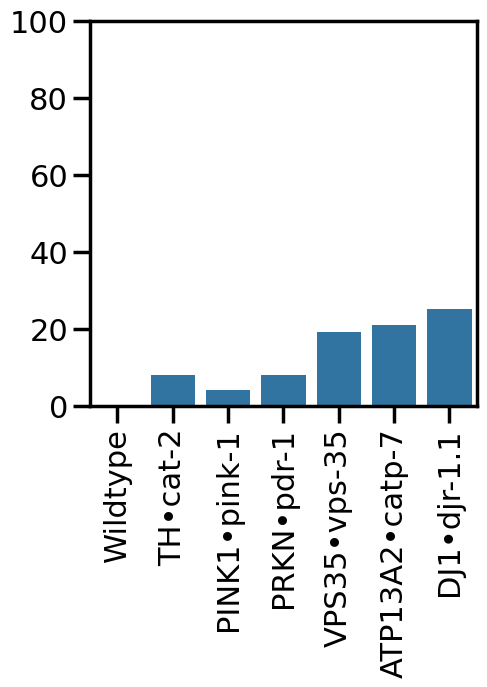

In [71]:
Title = "" #<---------------- Input Here -----------------
FileName = "Curved CEP Dendrites 4 DO"
sns.set_context("poster")
plt.figure(linewidth = 1)
plt.figure(figsize=(5, 5))
plt.gca().xaxis.grid(False)
ax = sns.barplot(x="Genotype", 
                 y = '% Worms', 
                 data = CurvedCEP[CurvedCEP.Age == '4 D.O.'], #<--------------- Input Here -------------
                 hue = 'Age',
                #  palette = [sns.color_palette()[1]],
                 legend = False,
                 orient="x"
                )
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel("")
plt.xticks(rotation=90)
plt.ylabel("")
plt.ylim(top = 100)
# plt.ylim(bottom = -0.03)
plt.title("")
# plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.savefig(f'/Users/Joseph/Desktop/{FileName}.png', format='png', dpi=450, bbox_inches = 'tight')
plt.show()

<Figure size 640x480 with 0 Axes>

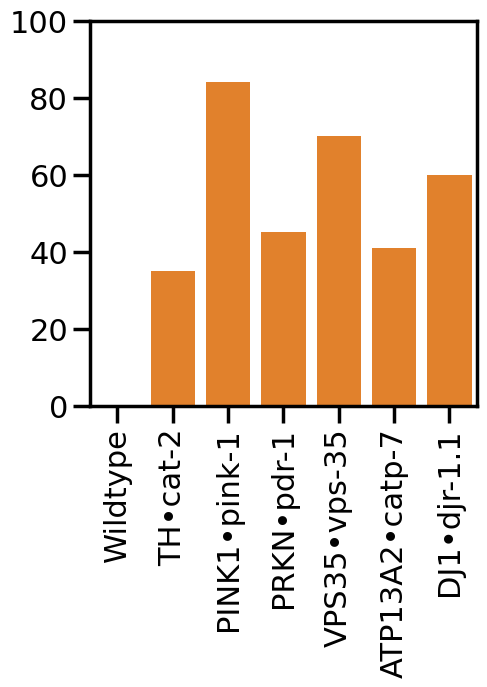

In [ ]:
Title = "" #<---------------- Input Here -----------------
FileName = "Rounded CEP Bodies 7 DO"
sns.set_context("poster")
plt.figure(linewidth = 1)
plt.figure(figsize=(5, 5))
plt.gca().xaxis.grid(False)
ax = sns.barplot(x="Genotype", 
                 y = '% Worms', 
                 data = RoundedCEP[RoundedCEP.Age == '7 D.O.'], #<--------------- Input Here -------------
                 hue = 'Age',
                 palette = [sns.color_palette()[1]],
                 legend = False,
                 orient="x"
                )
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel("")
plt.xticks(rotation=90)
plt.ylabel("")
plt.ylim(top = 100)
# plt.ylim(bottom = -0.03)
plt.title("")
# plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.savefig(f'/Users/Joseph/Desktop/{FileName}.png', format='png', dpi=450, bbox_inches = 'tight')
plt.show()

In [47]:
MeanChangeData = pd.read_csv(chooser.selected)
print(MeanChangeData)

                   Category  Change
0      Kinked CEP Processes       7
1      Kinked CEP Processes       6
2      Kinked CEP Processes      16
3      Kinked CEP Processes      17
4      Kinked CEP Processes      10
5      Kinked CEP Processes      27
6      Kinked CEP Processes      31
7      Kinked CEP Processes      31
8      Kinked CEP Processes      14
9      Kinked CEP Processes      22
10     Kinked CEP Processes      27
11     Kinked CEP Processes      33
12     Kinked CEP Processes      51
13     Kinked CEP Processes      40
14  Rounded CEP Cell Bodies       0
15  Rounded CEP Cell Bodies       0
16  Rounded CEP Cell Bodies      31
17  Rounded CEP Cell Bodies      32
18  Rounded CEP Cell Bodies      23
19  Rounded CEP Cell Bodies      35
20  Rounded CEP Cell Bodies      84
21  Rounded CEP Cell Bodies      36
22  Rounded CEP Cell Bodies       6
23  Rounded CEP Cell Bodies      46
24  Rounded CEP Cell Bodies      31
25  Rounded CEP Cell Bodies      35
26  Rounded CEP Cell Bodies 

<Figure size 640x480 with 0 Axes>

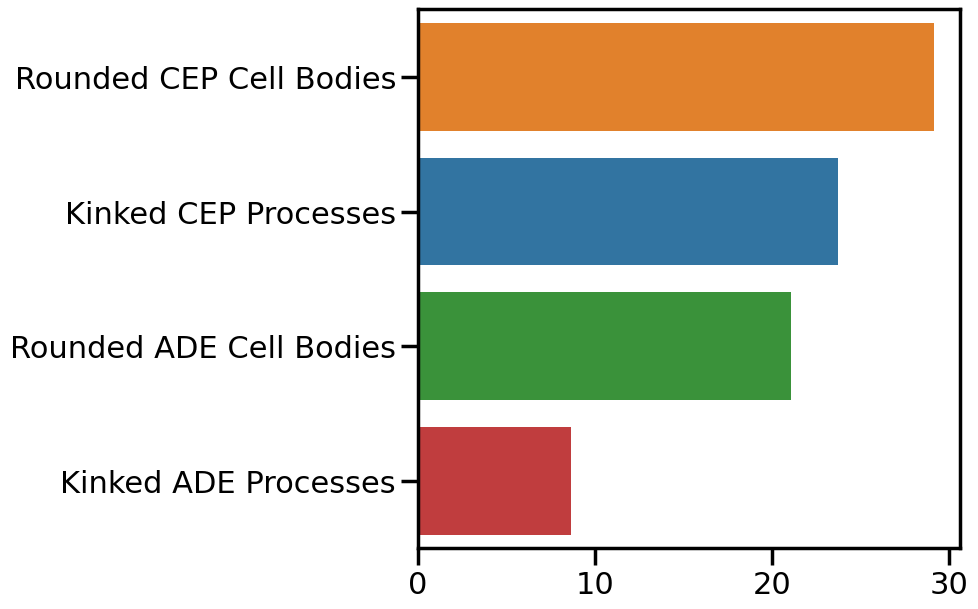

In [75]:
Title = "" #<---------------- Input Here -----------------
FileName = "MeanChange4DOto7DO_July14"
sns.set_context("poster")
plt.figure(linewidth = 1)
plt.figure(figsize=(7, 7))
plt.gca().xaxis.grid(False)
ax = sns.barplot(x="Change", 
                 y = 'Category', 
                 data = MeanChangeData, #<--------------- Input Here -------------
                 order = ['Rounded CEP Cell Bodies','Kinked CEP Processes','Rounded ADE Cell Bodies','Kinked ADE Processes'],
             # color = 'CornflowerBlue',
                 hue = 'Category',
                 # palette = [sns.color_palette()[1],'black'],
                 # palette = ['black',sns.color_palette()[0],sns.color_palette()[1]],
                 legend = False,
                 orient="y",
                 errorbar=None
             # edgecolor="DodgerBlue",
             # linewidth = 2.5,
#              seed=5,
#              ci = 95, # 'sd' for SD, '68' for SEM
#              palette = ['grey',
#                         'black'
#                        ]
                )
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel("")
# plt.xticks(rotation=90)
plt.ylabel("")
# plt.ylim(top = 0.2)
# plt.ylim(bottom = -0.03)
plt.title("")
# plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
plt.savefig(f'/Users/Joseph/Desktop/{FileName}.png', format='png', dpi=450, bbox_inches = 'tight')
plt.show()